---

## **1. Data Preprocessing**

### Load Data


In [3]:
#%conda install pandas

In [4]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('csv/data_cleaned.csv')
display(data.head())

# Calculate elapsed days
data['EllapsedDays'] = (datetime.now() - pd.to_datetime(data['Date'])).dt.days
display(data.head())

# Drop unnecessary columns
columns_to_drop = ['DATEADDED', 'ActionGeo_FullName', 'ActionGeo_Lat', 'ActionGeo_Long', 'Lag', 'LagCluster', 'Month']
data.drop(columns=columns_to_drop, inplace=True)
display(data.head())


,GlobalEventID,Date,DATEADDED,IsRootEvent,EventCode,EventBaseCode,EventRootCode,GoldsteinScale,NumMentions,AvgTone,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,Lag,LagCluster,Month
0,1218008600,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
1,1218059434,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,-6.250000,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
2,1217968727,2024-12-29,2024-12-29,1,111,111,11,-2.0,4,0.806952,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
3,1218064446,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,0.884956,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12
4,1218009043,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12


,GlobalEventID,Date,DATEADDED,IsRootEvent,EventCode,EventBaseCode,EventRootCode,GoldsteinScale,NumMentions,AvgTone,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,Lag,LagCluster,Month,EllapsedDays
0,1218008600,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,14
1,1218059434,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,-6.250000,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,14
2,1217968727,2024-12-29,2024-12-29,1,111,111,11,-2.0,4,0.806952,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,14
3,1218064446,2024-12-29,2024-12-29,1,90,90,9,-2.0,10,0.884956,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,14
4,1218009043,2024-12-29,2024-12-29,1,111,111,11,-2.0,3,6.336634,"Chicago, Illinois, United States",41.85,-87.6501,0,0,12,14


,GlobalEventID,Date,IsRootEvent,EventCode,EventBaseCode,EventRootCode,GoldsteinScale,NumMentions,AvgTone,EllapsedDays
0,1218008600,2024-12-29,1,111,111,11,-2.0,3,6.336634,14
1,1218059434,2024-12-29,1,90,90,9,-2.0,10,-6.250000,14
2,1217968727,2024-12-29,1,111,111,11,-2.0,4,0.806952,14
3,1218064446,2024-12-29,1,90,90,9,-2.0,10,0.884956,14
4,1218009043,2024-12-29,1,111,111,11,-2.0,3,6.336634,14



---

## **2. Data Preparation**

### Prepare Unique Event Codes and Rolling Sequences


In [5]:

# Convert 'Date' to datetime and find min/max dates
data['Date'] = pd.to_datetime(data['Date'])
min_date = data['Date'].min().date()
max_date = datetime.now().date()

print(f"Minimum date in the dataset: {min_date}")
print(f"Maximum date (today): {max_date}")

# Prepare unique event codes
unique_event_base_codes = sorted(data['EventBaseCode'].unique())
base_code_to_index = {code: idx for idx, code in enumerate(unique_event_base_codes)}
print(base_code_to_index)

# Create event count DataFrame
event_count_df = pd.DataFrame(columns=['Date'] + unique_event_base_codes)
event_count_df['Date'] = pd.date_range(start=min_date, end=max_date)

# Fill event counts
for date in event_count_df['Date']:
    day_data = data[data['Date'].dt.date == date.date()]
    for code in unique_event_base_codes:
        event_count_df.loc[event_count_df['Date'] == date, code] = day_data[day_data['EventBaseCode'] == code].shape[0]

# Fill NaN with 0
event_count_df.fillna(0, inplace=True)

# Display prepared DataFrame
display(event_count_df.head())


Minimum date in the dataset: 2020-01-02
Maximum date (today): 2025-01-12
{24: 0, 25: 1, 90: 2, 91: 3, 92: 4, 93: 5, 94: 6, 104: 7, 105: 8, 111: 9, 113: 10, 114: 11, 123: 12, 124: 13, 133: 14, 138: 15, 139: 16, 141: 17, 143: 18, 144: 19, 145: 20, 172: 21, 175: 22, 182: 23, 183: 24}


,Date,24,25,90,91,92,93,94,104,105,...,138,139,141,143,144,145,172,175,182,183
0,2020-01-02,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-03,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-05,0,0,6,0,0,0,0,0,0,...,0,0,5,2,0,0,0,0,0,0
4,2020-01-06,0,0,8,0,0,0,0,0,0,...,0,0,7,2,0,0,0,0,1,0


---

### Create TensorFlow Dataset



In [6]:
# Drop the 'Date' column
event_count_df.drop(columns=['Date'], inplace=True)

# Display the updated DataFrame
display(event_count_df.head())

,24,25,90,91,92,93,94,104,105,111,...,138,139,141,143,144,145,172,175,182,183
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,6,0,0,0,0,0,0,3,...,0,0,5,2,0,0,0,0,0,0
4,0,0,8,0,0,0,0,0,0,14,...,0,0,7,2,0,0,0,0,1,0


In [7]:
# Define rolling sequence length
sequence_length = 7

# Extract data and labels
event_data = event_count_df.values.astype('float32')  # All event counts
labels = event_count_df[145].values.astype('float32')  # Predict '145' event counts

# Create TensorFlow datasets
X_dataset = tf.data.Dataset.from_tensor_slices(event_data)
Y_dataset = tf.data.Dataset.from_tensor_slices(labels)

# Create rolling windows
X_sequences = X_dataset.window(sequence_length, shift=1, drop_remainder=True)
X_sequences = X_sequences.flat_map(lambda window: window.batch(sequence_length))
Y_labels = Y_dataset.skip(sequence_length)



2025-01-12 16:28:14.464219: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-01-12 16:28:14.464239: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2025-01-12 16:28:14.464244: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2025-01-12 16:28:14.464427: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-12 16:28:14.464441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# Combine features and labels
dataset = tf.data.Dataset.zip((X_sequences, Y_labels))

In [9]:
# Extract the first sequence and label from the dataset
for x_seq, y_label in dataset.take(1):
	first_x_seq = x_seq
	first_y_label = y_label

# Convert x_seq to a DataFrame
x_df = pd.DataFrame(first_x_seq.numpy(), columns=unique_event_base_codes)
display(x_df)

# Print y_label
print(f"Value of column 145 on the 8th row: {first_y_label.numpy()}")

2025-01-12 16:28:14.548546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,24,25,90,91,92,93,94,104,105,111,...,138,139,141,143,144,145,172,175,182,183
0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,...,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,...,4.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Value of column 145 on the 8th row: 1.0


---

Compared to the following -- the example below is a correct formulation.

---

In [10]:
# Display the first 7 rows of event_count_df
first_7_rows_df = event_count_df.head(7)
display(first_7_rows_df)

# Get the value of column 145 on the 8th row
value_8th_row_col_145 = event_count_df.iloc[7][145]
print(f"Value of column 145 on the 8th row: {value_8th_row_col_145}")

,24,25,90,91,92,93,94,104,105,111,...,138,139,141,143,144,145,172,175,182,183
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,6,0,0,0,0,0,0,3,...,0,0,5,2,0,0,0,0,0,0
4,0,0,8,0,0,0,0,0,0,14,...,0,0,7,2,0,0,0,0,1,0
5,0,0,11,0,0,0,0,0,0,21,...,0,0,3,0,0,0,0,0,0,0
6,0,0,22,0,0,0,0,0,0,12,...,4,0,6,0,1,0,0,0,0,0


Value of column 145 on the 8th row: 1


---

Ok good - the values look accurate!

That's fantastic. 

Let's go ahead and do the test / train split.

---

---

I had some issues with the test / train data set having values that were too high / too low and this threw off the validation and test data error over time, so I could have normalized the error, or I figured it would be more interesting to randomly assign the training and testing data, so that both data sets had equal exposure to ranges of the labels. 

This might be ill advised for LSTM, so I might change this later.

---

In [11]:
# Split into train/test sets (50/50 split)
split_index = len(event_data) // 2
train_dataset = dataset.take(split_index).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = dataset.skip(split_index).batch(32).prefetch(tf.data.AUTOTUNE)



---

## **3. Model Building and Training**

### Build LSTM Model


In [12]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, len(unique_event_base_codes))),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Add callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=callbacks
)


/opt/anaconda3/envs/civil_unrest/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,251 (59.57 KB)

 Trainable params: 15,251 (59.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2025-01-12 16:28:14.966420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-12 16:28:14.970344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


     29/Unknown 2s 52ms/step - loss: 68.7877 - mae: 3.3699

2025-01-12 16:28:17.110315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:17.110332: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12 16:28:17.110337: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6814147669319791166
2025-01-12 16:28:17.110343: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9851344591712727664
2025-01-12 16:28:17.110348: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7811744218594260802
2025-01-12 16:28:17.110446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 67.9060 - mae: 3.3404 - val_loss: 8.2740 - val_mae: 1.1196
Epoch 2/50
 2/29 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.2879 - mae: 1.2382

2025-01-12 16:28:17.725926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:17.725945: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:17.725947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/zeros_1/Const/_24]]
2025-01-12 16:28:17.725963: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:17.725968: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:17.725973: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelle

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 54.3345 - mae: 2.7567

2025-01-12 16:28:19.214558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:19.214582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_88]]
2025-01-12 16:28:19.214589: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2618883185442856579
2025-01-12 16:28:19.214594: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2855099374533244073
2025-01-12 16:28:19.214600: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1482154865207612425
2025-01-12 16:28:19.214604: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvou

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 53.6684 - mae: 2.7367 - val_loss: 5.7015 - val_mae: 0.9316
Epoch 3/50
 2/29 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 2.0596 - mae: 1.1877

2025-01-12 16:28:19.649467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:19.649499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/while/body/_15/sequential_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-12 16:28:19.649507: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:19.649523: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:19.649539: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:19.649544: I tensorflow/core/framewo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 41.6770 - mae: 2.4606

2025-01-12 16:28:21.060781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:21.060849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_42]]
2025-01-12 16:28:21.060879: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9736007440751978740
2025-01-12 16:28:21.060887: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 664889648719407540
2025-01-12 16:28:21.060892: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17053747101729795638
2025-01-12 16:28:21.060899: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 41.1920 - mae: 2.4468 - val_loss: 7.2391 - val_mae: 0.9779
Epoch 4/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.8694 - mae: 1.0295

2025-01-12 16:28:21.459090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:21.459109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/while/body/_15/sequential_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-12 16:28:21.459127: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:21.459132: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:21.459136: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5981210660290239565
2025-01-12 16:28:21.459141: I tensorflow/core/framewo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 39.7270 - mae: 2.3345

2025-01-12 16:28:22.648458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:22.648479: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4036547536857252214
2025-01-12 16:28:22.648483: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14539282545490977328
2025-01-12 16:28:22.648488: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17499456058052532622
2025-01-12 16:28:22.648492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_96]]
2025-01-12 16:28:22.648509: I tensorflow/core/framewor

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 39.2361 - mae: 2.3202 - val_loss: 3.5357 - val_mae: 0.9103
Epoch 5/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.6751 - mae: 1.0213

2025-01-12 16:28:22.982080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:22.982104: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:22.982113: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:22.982117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayUnstack/TensorListFromTensor/_22]]
2025-01-12 16:28:22.982136: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:22.982141: I tensorflow/core/framework/local_rendezvous.cc:422] Local ren

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 32.2166 - mae: 2.2144

2025-01-12 16:28:24.464430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:24.464462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_88]]
2025-01-12 16:28:24.464476: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2618883185442856579
2025-01-12 16:28:24.464481: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1482154865207612425
2025-01-12 16:28:24.464486: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2855099374533244073
2025-01-12 16:28:24.464490: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvou

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 31.8441 - mae: 2.2031 - val_loss: 5.0222 - val_mae: 0.9725
Epoch 6/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.7078 - mae: 0.9794

2025-01-12 16:28:24.891407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:24.891430: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:24.891439: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:24.891444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_16]]
2025-01-12 16:28:24.891463: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:24.891472: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14593492262192

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 30.7713 - mae: 2.3010

2025-01-12 16:28:26.082094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:26.082110: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12 16:28:26.082115: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4036547536857252214
2025-01-12 16:28:26.082122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_94]]
2025-01-12 16:28:26.082141: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10408148039663544792
2025-01-12 16:28:26.082160: I tensorflow/core/framework

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 30.4079 - mae: 2.2867 - val_loss: 4.4566 - val_mae: 0.9152
Epoch 7/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.1970 - mae: 0.7891

2025-01-12 16:28:26.420384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:26.420399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_38]]
2025-01-12 16:28:26.420406: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:26.420410: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2633077933252540157
2025-01-12 16:28:26.420413: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:26.420416: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 29.0019 - mae: 2.2231

2025-01-12 16:28:27.577675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:27.577698: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4036547536857252214
2025-01-12 16:28:27.577707: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14539282545490977328
2025-01-12 16:28:27.577713: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17499456058052532622
2025-01-12 16:28:27.577717: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 515514720697460628
2025-01-12 16:28:27.577721: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9736007440751978740
2025-01-12 16:28:27.577725: I tensorflow/core/framework/local_rendezvo

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 28.6820 - mae: 2.2147 - val_loss: 6.6250 - val_mae: 0.9749
Epoch 8/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.2642 - mae: 0.8132

2025-01-12 16:28:27.915873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:27.915887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_38]]
2025-01-12 16:28:27.915912: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:27.915921: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2633077933252540157
2025-01-12 16:28:27.915925: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:27.915930: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvo

28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 23.1282 - mae: 2.0434

2025-01-12 16:28:29.093620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:29.093643: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 515514720697460628
2025-01-12 16:28:29.093646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_88]]
2025-01-12 16:28:29.093669: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 829919236535799309
2025-01-12 16:28:29.093675: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1482154865207612425
2025-01-12 16:28:29.093682: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 22.5987 - mae: 2.0223 - val_loss: 5.4347 - val_mae: 0.9684
Epoch 9/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.3641 - mae: 0.8748

2025-01-12 16:28:29.437563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:29.437577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_38]]
2025-01-12 16:28:29.437583: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:29.437587: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:29.437593: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5981210660290239565
2025-01-12 16:28:29.437618: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 19.2430 - mae: 1.8509

2025-01-12 16:28:30.587926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:30.587951: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4906883216121307156
2025-01-12 16:28:30.587975: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11495412850204173080
2025-01-12 16:28:30.587990: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15880137122793607652
2025-01-12 16:28:30.587994: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9736007440751978740
2025-01-12 16:28:30.587999: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 664889648719407540
2025-01-12 16:28:30.588002: I tensorflow/core/framework/local_rendezvo

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 19.0345 - mae: 1.8440 - val_loss: 3.9388 - val_mae: 0.9216
Epoch 10/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.3128 - mae: 0.9013

2025-01-12 16:28:30.925035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:30.925055: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:30.925066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_12]]
2025-01-12 16:28:30.925088: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14593492262192220676
2025-01-12 16:28:30.925098: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:30.925110: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10866188148969840355
2025-0

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 25.6483 - mae: 2.1012

2025-01-12 16:28:32.101092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:32.101106: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12 16:28:32.101111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_4/_54]]
2025-01-12 16:28:32.101125: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2497584147181902314
2025-01-12 16:28:32.101144: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13121556321451465614
2025-01-12 16:28:32.101153: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1172641185

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 25.3707 - mae: 2.0898 - val_loss: 3.2487 - val_mae: 0.9361
Epoch 11/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.1648 - mae: 0.7746

2025-01-12 16:28:32.436483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:32.436500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/while/body/_15/sequential_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-12 16:28:32.436517: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:32.436526: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:32.436529: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4150942548537816270
2025-01-12 16:28:32.436530: I tensorflow/core/framewor

28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 24.0940 - mae: 2.0962

2025-01-12 16:28:33.656005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:33.656020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_6/_56]]
2025-01-12 16:28:33.656027: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 829919236535799309
2025-01-12 16:28:33.656032: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1482154865207612425
2025-01-12 16:28:33.656035: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2855099374533244073
2025-01-12 16:28:33.656039: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 184161894640

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 23.5661 - mae: 2.0789 - val_loss: 5.8631 - val_mae: 0.9648
Epoch 12/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.4198 - mae: 0.9036

2025-01-12 16:28:33.991002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/zeros_1/Const/_24]]
2025-01-12 16:28:33.991022: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:33.991031: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:33.991035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:33.991053: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14593492262192220676
2025-01-12 16:28:33.991066: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancell

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 21.5519 - mae: 1.9602

2025-01-12 16:28:35.136187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:35.136205: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15880137122793607652
2025-01-12 16:28:35.136210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_88]]
2025-01-12 16:28:35.136216: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4615613708195319595
2025-01-12 16:28:35.136220: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 829919236535799309
2025-01-12 16:28:35.136224: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvou

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 21.3065 - mae: 1.9506 - val_loss: 2.7631 - val_mae: 0.8726
Epoch 13/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.1767 - mae: 0.8833

2025-01-12 16:28:35.466978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:35.466996: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:35.466999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/while/body/_15/sequential_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-12 16:28:35.467010: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:35.467022: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14593492262192220676
2025-01-12 16:28:35.467028: I tensorflow/core/framew

28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 19.7144 - mae: 1.9661

2025-01-12 16:28:36.663928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:36.663948: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9736007440751978740
2025-01-12 16:28:36.663953: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 664889648719407540
2025-01-12 16:28:36.663967: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17053747101729795638
2025-01-12 16:28:36.663972: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12 16:28:36.663976: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6814147669319791166
2025-01-12 16:28:36.663983: I tensorflow/core/framework/local_rendezvou

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 19.2703 - mae: 1.9481 - val_loss: 3.9007 - val_mae: 0.9691
Epoch 14/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.6618 - mae: 0.9768

2025-01-12 16:28:36.995117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:36.995133: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:36.995142: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4150942548537816270
2025-01-12 16:28:36.995149: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:36.995153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/while/body/_15/sequential_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-12 16:28:36.995170: I tensorflow/core/framewo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 17.6727 - mae: 1.9434

2025-01-12 16:28:38.129666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:38.129687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_88]]
2025-01-12 16:28:38.129695: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18275019201661150825
2025-01-12 16:28:38.129699: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18416189464043227131
2025-01-12 16:28:38.129704: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2847972565961476233
2025-01-12 16:28:38.129708: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezv

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 17.4643 - mae: 1.9317 - val_loss: 3.5668 - val_mae: 0.9475
Epoch 15/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.4474 - mae: 0.8942

2025-01-12 16:28:38.463141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:38.463157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_14]]
2025-01-12 16:28:38.463164: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:38.463167: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:38.463171: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8318025325778589956
2025-01-12 16:28:38.463174: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10866188148969840355
2025-01

28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 20.4747 - mae: 2.0585

2025-01-12 16:28:39.651123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:39.651137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_88]]
2025-01-12 16:28:39.651144: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10408148039663544792
2025-01-12 16:28:39.651149: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2618883185442856579
2025-01-12 16:28:39.651154: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1482154865207612425
2025-01-12 16:28:39.651158: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvo

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 20.0021 - mae: 2.0348 - val_loss: 6.8380 - val_mae: 0.9285
Epoch 16/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.2372 - mae: 0.8064

2025-01-12 16:28:40.006837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:40.006860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/while/body/_15/sequential_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-12 16:28:40.006880: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:40.006894: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:40.006906: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:40.006917: I tensorflow/core/framewo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 18.0796 - mae: 1.8959

2025-01-12 16:28:41.180793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:41.180811: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12 16:28:41.180816: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6814147669319791166
2025-01-12 16:28:41.180820: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7811744218594260802
2025-01-12 16:28:41.180824: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17499456058052532622
2025-01-12 16:28:41.180829: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8766744092912245448
2025-01-12 16:28:41.180832: I tensorflow/core/framework/local_rendezvo

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 17.8688 - mae: 1.8863 - val_loss: 2.4565 - val_mae: 0.8692
Epoch 17/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.3080 - mae: 0.8248

2025-01-12 16:28:41.513886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:41.513903: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:41.513907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_14]]
2025-01-12 16:28:41.513921: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:41.513925: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10866188148969840355
2025-01-12 16:28:41.513928: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 14.6241 - mae: 1.8366

2025-01-12 16:28:42.694157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:42.694186: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12 16:28:42.694191: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6814147669319791166
2025-01-12 16:28:42.694192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_4/_54]]
2025-01-12 16:28:42.694209: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17499456058052532622
2025-01-12 16:28:42.694217: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2855099374

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 14.4745 - mae: 1.8302 - val_loss: 4.2929 - val_mae: 0.8892
Epoch 18/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.2627 - mae: 0.8585

2025-01-12 16:28:43.028376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:43.028398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_38]]
2025-01-12 16:28:43.028407: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:43.028411: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:43.028414: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5981210660290239565
2025-01-12 16:28:43.028417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 10.8160 - mae: 1.6208

2025-01-12 16:28:44.198832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:44.198850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12 16:28:44.198858: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6814147669319791166
2025-01-12 16:28:44.198862: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11726411853604641568
2025-01-12 16:28:44.198866: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9513541646276622008
2025-01-12 16:28:44.198874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Ad

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 10.6974 - mae: 1.6136 - val_loss: 2.5744 - val_mae: 0.8525
Epoch 19/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.8578 - mae: 0.6988

2025-01-12 16:28:44.534072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:44.534085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/zeros_1/Const/_23]]
2025-01-12 16:28:44.534092: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:44.534094: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:44.534098: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:44.534101: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelle

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 19.3706 - mae: 1.7886

2025-01-12 16:28:45.734365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:45.734385: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12 16:28:45.734399: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6814147669319791166
2025-01-12 16:28:45.734404: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17499456058052532622
2025-01-12 16:28:45.734409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_6/_56]]
2025-01-12 16:28:45.734428: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1172641185

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 19.1344 - mae: 1.7803 - val_loss: 8.9017 - val_mae: 0.9349
Epoch 20/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.2285 - mae: 0.8783

2025-01-12 16:28:46.068220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:46.068232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/while/body/_15/sequential_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-12 16:28:46.068251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:46.068257: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:46.068260: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5981210660290239565
2025-01-12 16:28:46.068264: I tensorflow/core/framewo

28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9.8362 - mae: 1.6064 

2025-01-12 16:28:47.233004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:47.233019: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12 16:28:47.233034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_88]]
2025-01-12 16:28:47.233052: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 664889648719407540
2025-01-12 16:28:47.233062: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16739285100919370838
2025-01-12 16:28:47.233067: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvou

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 9.6375 - mae: 1.5919 - val_loss: 3.2636 - val_mae: 0.9709
Epoch 21/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.7858 - mae: 0.7262

2025-01-12 16:28:47.566723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:47.566744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/while/body/_15/sequential_1/lstm_1/while/TensorArrayV2Read/TensorListGetItem/_44]]
2025-01-12 16:28:47.566761: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:47.566770: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:47.566783: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:47.566795: I tensorflow/core/framewo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 12.6470 - mae: 1.7368

2025-01-12 16:28:48.711182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:48.711201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4906883216121307156
2025-01-12 16:28:48.711221: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11495412850204173080
2025-01-12 16:28:48.711234: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 664889648719407540
2025-01-12 16:28:48.711245: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15599690852599654704
2025-01-12 16:28:48.711247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequent

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 12.5128 - mae: 1.7310 - val_loss: 5.6288 - val_mae: 0.9737
Epoch 22/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.7488 - mae: 0.6577

2025-01-12 16:28:49.044962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:49.044983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_38]]
2025-01-12 16:28:49.044991: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:49.044995: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:49.044998: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5981210660290239565
2025-01-12 16:28:49.045001: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 11.5158 - mae: 1.7127

2025-01-12 16:28:50.195523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:50.195541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4906883216121307156
2025-01-12 16:28:50.195545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_42]]
2025-01-12 16:28:50.195573: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15599690852599654704
2025-01-12 16:28:50.195584: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9851344591712727664
2025-01-12 16:28:50.195590: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1099464639202710590
2025-01-1

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 11.3918 - mae: 1.7052 - val_loss: 6.5127 - val_mae: 1.0260
Epoch 23/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.6885 - mae: 0.5645

2025-01-12 16:28:50.546623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:50.546638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_38]]
2025-01-12 16:28:50.546645: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:50.546650: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2633077933252540157
2025-01-12 16:28:50.546654: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:50.546658: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 9.9975 - mae: 1.5883 

2025-01-12 16:28:51.689020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:51.689038: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4036547536857252214
2025-01-12 16:28:51.689046: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14539282545490977328
2025-01-12 16:28:51.689054: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11726411853604641568
2025-01-12 16:28:51.689058: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 515514720697460628
2025-01-12 16:28:51.689060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequent

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 9.9013 - mae: 1.5835 - val_loss: 5.4748 - val_mae: 1.0302
Epoch 24/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.3499 - mae: 0.8257

2025-01-12 16:28:52.015676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:52.015690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_38]]
2025-01-12 16:28:52.015700: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:52.015704: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:52.015708: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5981210660290239565
2025-01-12 16:28:52.015712: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.3022 - mae: 1.5184

2025-01-12 16:28:53.159947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:53.159963: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12 16:28:53.159967: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16739285100919370838
2025-01-12 16:28:53.159972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_42]]
2025-01-12 16:28:53.159990: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9736007440751978740
2025-01-12 16:28:53.159998: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2497584147181902314
2025-01-1

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.2338 - mae: 1.5111 - val_loss: 3.2594 - val_mae: 0.8950
Epoch 25/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.6990 - mae: 0.6410

2025-01-12 16:28:53.491398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:53.491417: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:53.491426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10057512693181217186
2025-01-12 16:28:53.491430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/zeros_1/Const/_24]]
2025-01-12 16:28:53.491456: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14593492262192220676
2025-01-12 16:28:53.491466: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancell

28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 9.5148 - mae: 1.5500

2025-01-12 16:28:54.657750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:54.657773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_10/_46]]
2025-01-12 16:28:54.657791: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4906883216121307156
2025-01-12 16:28:54.657795: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15379472836052295592
2025-01-12 16:28:54.657800: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9736007440751978740
2025-01-12 16:28:54.657805: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 664889648

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 9.3219 - mae: 1.5397 - val_loss: 4.7622 - val_mae: 0.9836
Epoch 26/50
 3/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.9400 - mae: 0.7260

2025-01-12 16:28:54.987554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:54.987569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_38]]
2025-01-12 16:28:54.987594: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:54.987602: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:54.987606: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5981210660290239565
2025-01-12 16:28:54.987610: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.3957 - mae: 1.5053

2025-01-12 16:28:56.137144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:56.137159: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3997349873847865624
2025-01-12 16:28:56.137165: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2497584147181902314
2025-01-12 16:28:56.137173: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11726411853604641568
2025-01-12 16:28:56.137178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_42]]
2025-01-12 16:28:56.137191: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8766744092912245448
2025-01-1

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7.3320 - mae: 1.4993 - val_loss: 3.8295 - val_mae: 0.9026


2025-01-12 16:28:56.469218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:56.469235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/TensorArrayV2Stack/TensorListStack/_38]]
2025-01-12 16:28:56.469241: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:56.469246: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2633077933252540157
2025-01-12 16:28:56.469251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15932638970796493643
2025-01-12 16:28:56.469254: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvo



---

## **4. Evaluate and Visualize Results**

### Evaluate Model


In [13]:

# Evaluate the model
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3106 - mae: 0.7121
Test Loss: 2.4565000534057617, Test MAE: 0.8691881895065308


2025-01-12 16:28:56.831691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-01-12 16:28:56.831708: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8345727479572726018
2025-01-12 16:28:56.831713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/lstm_1/zeros_1/Const/_24]]
2025-01-12 16:28:56.831726: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3295238247110939275
2025-01-12 16:28:56.831736: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14593492262192220676
2025-01-12 16:28:56.831743: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelle

---

The final training loss was 24.27 with a corresponding Mean Absolute Error (MAE) of 1.72, indicating that, on average, the model’s predictions on the training data were off by about 1.72 units. On the test dataset, the model achieved a Test Loss of 12.99 and a Test MAE of 1.21, showing improved performance on unseen data. This suggests that the model generalizes reasonably well, with an average prediction error of 1.21 units on the test set.

---



### Visualize Training and Predictions


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


2025-01-12 16:28:57.307503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-12 16:28:57.381515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


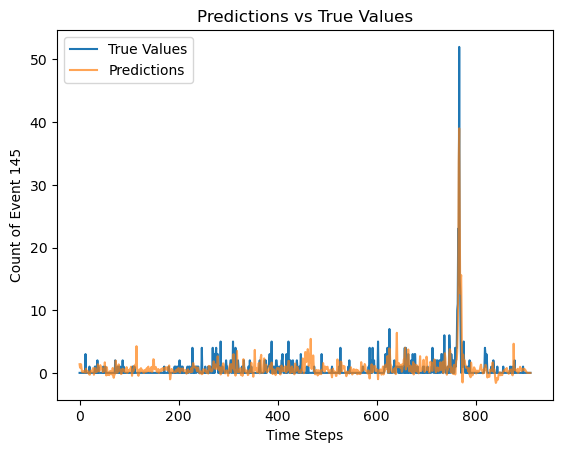

In [14]:
import numpy as np

# Make predictions
predictions = model.predict(test_dataset)

# Visualize predictions vs true values
true_values = np.concatenate([label.numpy() for _, label in test_dataset])
plt.plot(true_values, label='True Values')
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.title('Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Count of Event 145')
plt.legend()
plt.show()

---

The plot shows that the model generally tracks the overall trend of the true values but struggles to capture the magnitude of sharp spikes, resulting in underestimation during significant event peaks. While the model performs well during periods of lower activity, its inability to fully predict extreme values highlights a limitation in handling highly variable or sudden changes in event counts. 

---

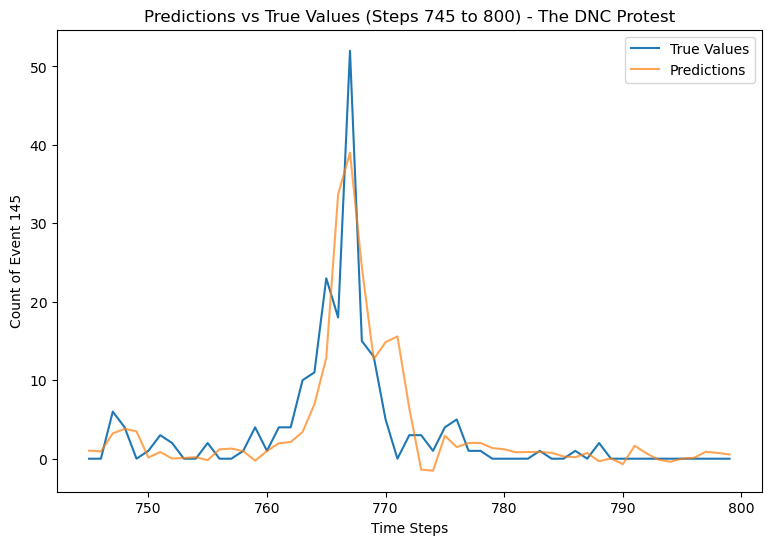

In [17]:
# Define the range for plotting
start_step_dnc = 745
end_step_dnc = 800

# Extract the relevant range of true values and predictions for DNC
true_values_range_dnc = true_values[start_step_dnc:end_step_dnc]
predictions_range_dnc = predictions[start_step_dnc:end_step_dnc]

# Extract the relevant range of true values and predictions for George Floyd
true_values_range_gf = true_values[start_step_gf:end_step_gf]
predictions_range_gf = predictions[start_step_gf:end_step_gf]

# Plot the true values and predictions for DNC
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(range(start_step_dnc, end_step_dnc), true_values_range_dnc, label='True Values')
plt.plot(range(start_step_dnc, end_step_dnc), predictions_range_dnc, label='Predictions', alpha=0.7)
plt.title(f'Predictions vs True Values (Steps {start_step_dnc} to {end_step_dnc}) - The DNC Protest')
plt.xlabel('Time Steps')
plt.ylabel('Count of Event 145')
plt.legend()

plt.show()

---

Notice how the model consistantly lags the true values. This is not ideal, but maybe it still has ethicacy.

It seems the spike at step ~65 was proactively predicted, but I'm not sure.

---

---

## **5. Analyze Results**

### Analyze Performance


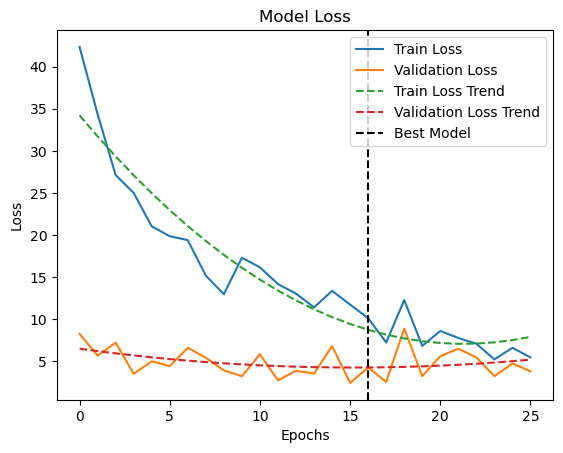

In [16]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Fit parabolic trend curves
epochs = np.arange(len(history.history['loss']))
train_poly = np.poly1d(np.polyfit(epochs, history.history['loss'], 2))
val_poly = np.poly1d(np.polyfit(epochs, history.history['val_loss'], 2))

# Plot parabolic trend curves
plt.plot(epochs, train_poly(epochs), label='Train Loss Trend', linestyle='--')
plt.plot(epochs, val_poly(epochs), label='Validation Loss Trend', linestyle='--')

# Add vertical line for the best model
best_epoch = len(history.history['loss']) - 10
plt.axvline(x=best_epoch, color='black', linestyle='--', label='Best Model')

plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

---

The plot shows that while **training loss** decreases steadily, **validation loss** fluctuates and stabilizes around epoch 10, indicating potential **overfitting**. The model continues to improve on training data, but its performance on unseen data does not. 

The model uses **early stopping with a patience of 10 epochs**, meaning it continues training for 10 additional epochs after finding the best model. As a result, the model with the lowest error is at epoch 11, since the final epoch is 21 (21 - 10 = 11).

---


### **Summary & Takeaway**

The model performs reasonably well in capturing general trends but consistently underestimates sharp spikes in event counts, particularly during periods of high activity. While the **Test MAE of 1.21** indicates that the model is relatively accurate during low to moderate event levels, its inability to predict large surges limits its effectiveness in critical scenarios. This suggests the current feature set may be insufficient for capturing complex patterns or extreme fluctuations in the data.

### **Next Steps**

1. **Add More Features**: Incorporate additional features such as **avgTone** to provide more context and potentially improve the model's ability to differentiate between normal and high-activity periods.
   
2. **Categorical Label Definition**: Instead of predicting the exact count of events, redefine the label categorically by classifying dates as either **"safe"** or **"unsafe"**, where "unsafe" represents dates with more than **20 events**. This could simplify the problem and improve the model's predictive power for identifying high-risk periods. 

